In [13]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils import generate_data_object_synthetic

from sklearn.manifold import TSNE
import json

In [14]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def line_plot_with_std(list_scores, fname):

    # Convert the list of lists to a Pandas DataFrame
    df = pd.DataFrame(list_scores)

    # Calculate the mean and standard deviation of each row
    mean = df.mean(axis=1)
    std = df.std(axis=1)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean, color='blue', label='Mean')

    # Plot the shaded region around the mean line
    ax.fill_between(df.index, mean-std, mean+std, color='lightblue', alpha=0.5, label='Standard deviation')

    # Add some labels and a legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    # ax.legend()

    # Show and save the plot
    plt.grid()
    plt.xlabel('Number of tasks per student')
    plt.ylabel('Balanced Accuracy')
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [15]:
def visualise_embeddings(json_content, fname):
    embeddings = json_content["embeddings"]
    embeddings_students = embeddings['student']
    embeddings_items = embeddings["item"]
    student_ability = json_content['student_ability']
    item_difficulty = json_content["item_difficulty"]

    def plot_tsne(embeddings, targets, title, ax):
        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(np.array(embeddings))

        # Plotting the scatter plot
        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap='viridis')
        ax.set_title(title)
        # ax.set_xlabel('t-SNE Dimension 1')
        # ax.set_ylabel('t-SNE Dimension 2')


    # Creating subplots for t-SNE visualization
    fig, ax = plt.subplots(ncols = 2, figsize=(8,6))

    plot_tsne(embeddings_items, item_difficulty, 'Items and Difficulties', ax[0])
    plot_tsne(embeddings_students, student_ability, 'Students and Abilities', ax[1])

    plt.tight_layout()
    part1, part2 = fname.split('.')
    part1 = part1 + '_scatter'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [16]:
from IPython.utils import io
import matplotlib.pyplot as plt

import string
def create_filename_results(parameters,fold):
    file_name = ' '.join([f"{str(key)}-{str(value)}" for key, value in parameters.items() if key not in ['max_n_tasks_per_student','min_n_tasks_per_student']])
    file_name += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(4))
    file_name.replace(".","")
    file_name+=".results"
    return os.path.join(fold, file_name)


#n_students_per_task_list = [2**i for i in n_students_per_task_list]

import json
def synthetic_density_effect_runs(parameters,parameters_density, folder = 'synth_density_effect'):
    parameters = {**parameters, **parameters_density}
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    scores = []
    list_scores = []
    for n_task_per_student in tqdm(n_tasks_per_student_list):
        with io.capture_output() as captured:
            data = generate_data_object_synthetic(
                n_students = parameters['n_students'], # 72% of nodes were students
                n_tasks = parameters['n_tasks'],
                n_task_per_student = n_task_per_student,
                error_proness_denom = parameters['error_proness_denom'],
                probabilistic = parameters['probabilistic'],
                number_of_tasks_per_students_is_max=parameters['number_of_tasks_per_students_is_max'])

            cv_out = perform_cross_validation(data, parameters, save_embeddings=True)
            embeddings = cv_out['embedding_0']
            embeddings = {key:values.cpu().detach().numpy().tolist() for key, values in embeddings.items()}
            student_ability = data['student'].ability.cpu().detach().view(-1).numpy().tolist()
            item_difficulty = data['item'].difficulty.cpu().detach().view(-1).numpy().tolist()
            score = 0
            inner_list_scores = []
            for fold_n in range(parameters["n_splits"]):
                score += cv_out[f"Balanced Accuracy_{fold_n}_test"]
                inner_list_scores.extend([cv_out[f"Balanced Accuracy_{fold_n}_test"]])
            score = score / parameters["n_splits"]
            scores.append(score)
            list_scores.append(inner_list_scores)

    res_dict = dict(zip(n_tasks_per_student_list,scores))
    output_dict = {
        **parameters,
        "embeddings":embeddings,
        'student_ability':student_ability,
        'item_difficulty':item_difficulty,
        "res_dict":res_dict,
        "list_scores":dict(zip(n_tasks_per_student_list,list_scores))
    }
    fname = create_filename_results(parameters_density, folder)
    with open(fname,'w') as f:
        json.dump(output_dict, f, skipkeys=True)
    
    # save results
    line_plot_with_std(list_scores=list_scores, fname=fname)

    # save embeddings
    visualise_embeddings(output_dict, fname=fname)


In [17]:
parameters = {
    "hidden_dims": [16, 8],
    'model_type': "GNN",
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 10000,
    "learning_rate": 0.005,
    "weight_decay": 0,
    "dropout": 0.4,
    "early_stopping": 200,
    "n_splits": 3,
    "device": "cuda",
    "done": False,
    "batch_size":128,
    #
    }

parameters_density = {
    'n_students' :720, # 72% of nodes were students
    'n_tasks':280,
    'max_n_tasks_per_student':280, 
    'min_n_tasks_per_student':5,
    'step_n_tasks_per_student':10,
    'error_proness_denom':None,
    'probabilistic':None,
    'number_of_tasks_per_students_is_max':None
}


  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [1:11:07<00:00, 152.42s/it]


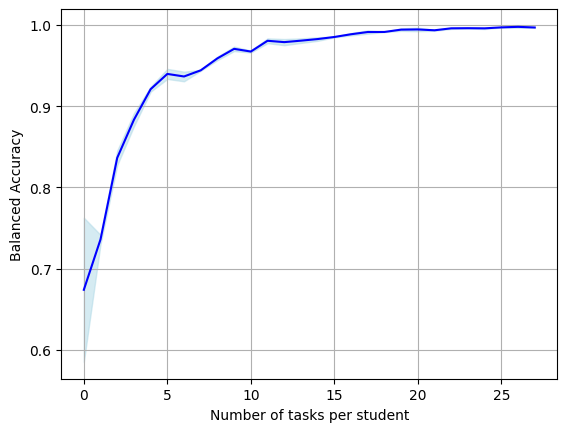

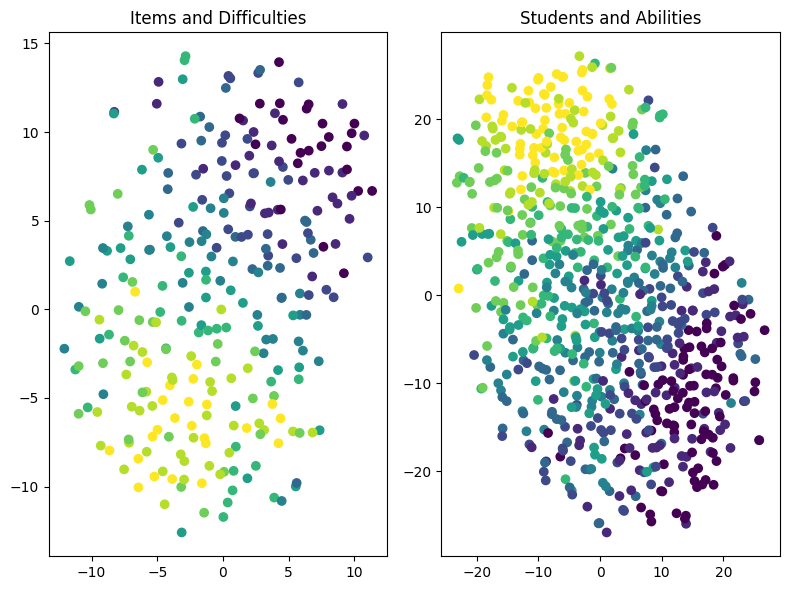

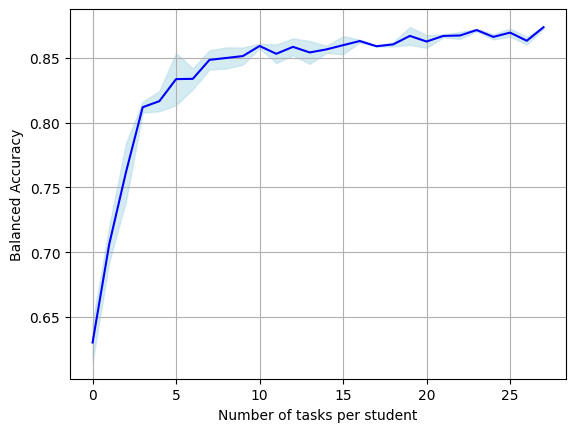

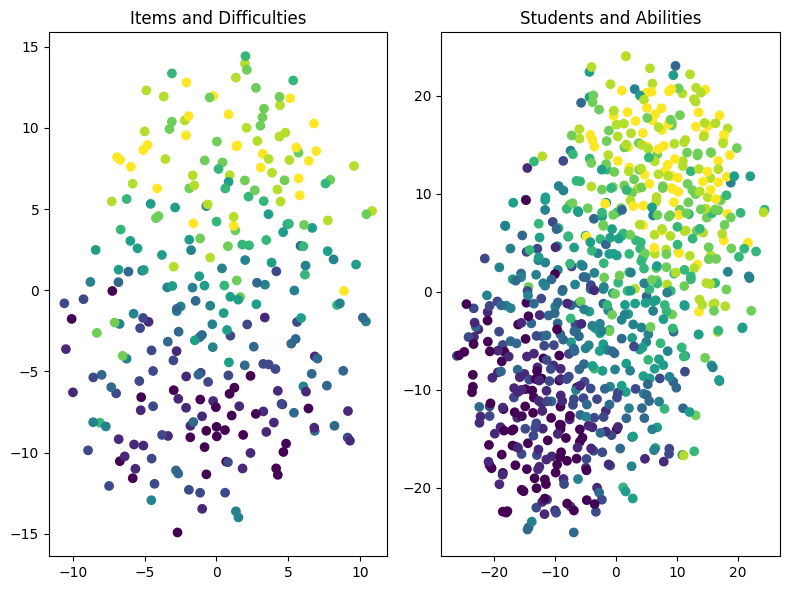

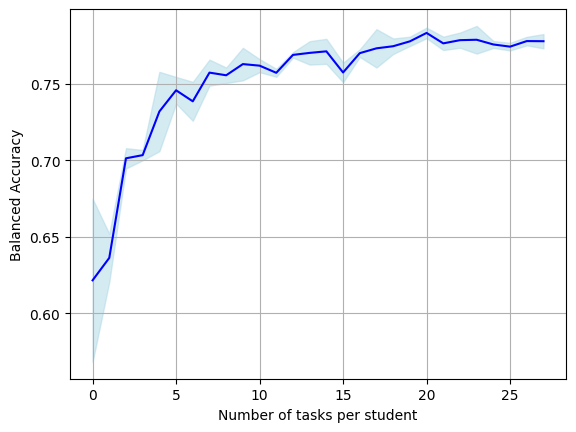

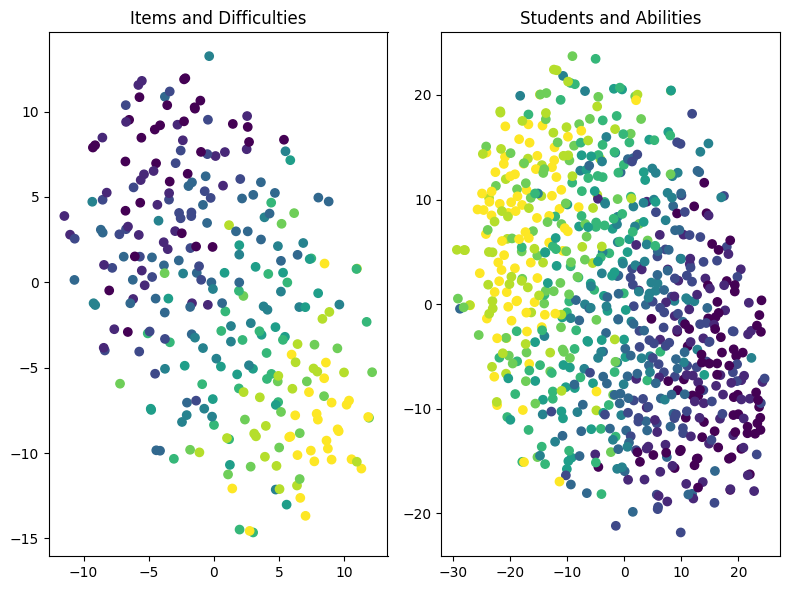

In [18]:
for probabilities in [1]:
    for error_proness_denom in [0,1,2]:
        if error_proness_denom == 0:
            parameters_density['probabilistic'] = 0
            # parameters_density['error_proness_denom'] = error_proness_denom
            parameters_density['number_of_tasks_per_students_is_max'] = 1#number_of_tasks_per_students_is_max
            synthetic_density_effect_runs(parameters=parameters,
                                          parameters_density=parameters_density,
                                          )
        else:
            for number_of_tasks_per_students_is_max in [1]:
                parameters_density['probabilistic'] = probabilities
                parameters_density['error_proness_denom'] = error_proness_denom
                parameters_density['number_of_tasks_per_students_is_max'] = 1#number_of_tasks_per_students_is_max
                synthetic_density_effect_runs(parameters=parameters,
                                            parameters_density=parameters_density,
                                            )

In [19]:
import numpy as np

In [20]:
def sigmoid(x, alpha):
    return 1/(1+np.exp(-x/alpha))

C:\Users\liq02qc\AppData\Local\Temp\ipykernel_33872\1727097957.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))
C:\Users\liq02qc\AppData\Local\Temp\ipykernel_33872\1727097957.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))


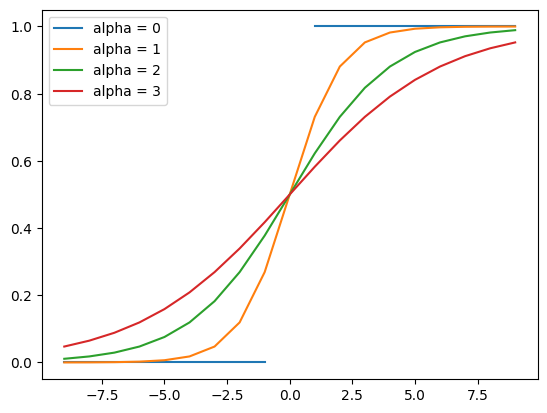

In [21]:
x = np.arange(-9,10)
plt.plot(x, [sigmoid(xi,0) for xi in x], label="alpha = 0")
plt.plot(x, [sigmoid(xi,1) for xi in x], label="alpha = 1")
plt.plot(x, [sigmoid(xi,2) for xi in x], label="alpha = 2")
plt.plot(x, [sigmoid(xi,3) for xi in x], label="alpha = 3")
plt.legend()